In [151]:
# KITTI sequence to raw data map
# Nr.     Sequence name     Start   End
# ---------------------------------------
# 00: 2011_10_03_drive_0027 000000 004540
# 01: 2011_10_03_drive_0042 000000 001100
# 02: 2011_10_03_drive_0034 000000 004660
# 03: 2011_09_26_drive_0067 000000 000800
# 04: 2011_09_30_drive_0016 000000 000270
# 05: 2011_09_30_drive_0018 000000 002760
# 06: 2011_09_30_drive_0020 000000 001100
# 07: 2011_09_30_drive_0027 000000 001100
# 08: 2011_09_30_drive_0028 001100 005170
# 09: 2011_09_30_drive_0033 000000 001590
# 10: 2011_09_30_drive_0034 000000 001200

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import pykitti
sys.path.append('../src')
from utils import lla_to_enu, normalize_angles

gt = np.load("../vo_estimates/trajectory_gt_09.npy")
vo = np.load("../vo_estimates/trajectory_estimated_09.npy")
imu = np.load("../vo_estimates/imu_09.npy")

%matplotlib inline
np.random.seed(777)

In [152]:
print(f'gps data shape: {gt.shape}')
print(f'vo data shape: {vo.shape}')
print(f'imu data shape: {imu.shape}')

gps data shape: (3, 1591)
vo data shape: (1594, 3)
imu data shape: (1594, 7)


In [153]:
# rotate and transform imu and camera coordinate into velodyne coordinate
gt.T

array([[ 5.551115e-17,  0.000000e+00,  2.220446e-16],
       [ 2.138869e-02, -8.456433e-03,  2.880714e-01],
       [ 3.879027e-02, -1.513783e-02,  5.807338e-01],
       ...,
       [-2.549688e+00,  3.071295e+00,  6.841526e+00],
       [-2.775305e+00,  3.058171e+00,  7.528465e+00],
       [-3.006582e+00,  3.045729e+00,  8.222648e+00]])

In [154]:
kitti_root_dir = '../data'
kitti_date = '2011_09_30'
kitti_drive = '0033'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

In [198]:
GPS_measurements = []  # [longitude(deg), latitude(deg), altitude(meter)] x N from GPS
VO_measurements = [] # [longitude(deg), latitude(deg)] x N from Visual Odometry
IMU_outputs = [] # [acc_x, acc_y, acc_z, ang_vel_x, ang_vel_y, ang_vel_z] x N from IMU
INS_angles = [] # [roll(rad), pitch(rad), yaw(rad)] x N
INS_velocities = [] # [forward velocity, leftward velocity, upward velocity] x N from INS

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    GPS_measurements.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    # when VO is available
    # VO_measurements.append([])
    IMU_outputs.append([
        packet.ax,
        packet.ay,
        packet.az,
        packet.wx,
        packet.wy,
        packet.wz
    ])
    INS_angles.append([
        packet.roll,
        packet.pitch,
        packet.yaw
    ])
    INS_velocities.append([
        packet.vf,
        packet.vl,
        packet.vu
    ])

GPS_measurements = np.array(GPS_measurements).T
VO_measurements = np.array(VO_measurements).T
IMU_outputs = np.array(IMU_outputs)
INS_angles = np.array(INS_angles)
INS_velocities = np.array(INS_velocities)

In [199]:
origin = GPS_measurements[:, 0]  # set the initial position to the origin
GPS_measurements_in_meter = lla_to_enu(GPS_measurements, origin)

In [200]:
print(f'gps data shape: {gt.shape}')
print(f'vo data shape: {vo.shape}')
print(f'imu data shape: {imu.shape}')

gps data shape: (3, 1591)
vo data shape: (1594, 3)
imu data shape: (1594, 7)


In [201]:
print(f'gps data shape: {GPS_measurements.shape}')
print(f'vo data shape: {vo.shape}')
print(f'imu data shape: {IMU_outputs.shape}')

gps data shape: (3, 1594)
vo data shape: (1594, 3)
imu data shape: (1594, 6)


In [202]:
def get_rigid_transformation(calib_path):
    with open(calib_path, 'r') as f:
        calib = f.readlines()

    R = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
    t = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

    T = np.vstack((np.hstack((R, t)), np.array([0, 0, 0, 1])))
    
    return T

In [203]:
T_velo_ref0 = get_rigid_transformation('../vo_estimates/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation('../vo_estimates/calib_imu_to_velo.txt')

In [204]:
T_from_imu_to_cam = T_imu_velo @ T_velo_ref0
T_from_cam_to_imu = np.linalg.inv(T_from_imu_to_cam)


imu_in_cam_coord = []
for imu_vals in imu:
    acc_imu = np.array([imu_vals[1], imu_vals[2], imu_vals[3], 1])
    gyr_imu = np.array([imu_vals[4], imu_vals[5], imu_vals[6], 1])
    transformed_acc_imu = T_from_imu_to_cam @ acc_imu
    transformed_gyr_imu = T_from_imu_to_cam @ gyr_imu
    imu_in_cam_coord.append([imu_vals[0], transformed_acc_imu[0], transformed_acc_imu[1], transformed_acc_imu[2], transformed_gyr_imu[0], transformed_gyr_imu[1], transformed_gyr_imu[2]])

cam_in_imu_coord = []
for vo_est in vo:
    VO = np.array([vo_est[0], vo_est[1], vo_est[2], 1])
    transformed = T_from_cam_to_imu @ VO
    cam_in_imu_coord.append([transformed[0], transformed[1], transformed[2]])

gt_in_imu_coord = []
for gt_est in gt.T:
    GT = np.array([gt_est[0], gt_est[1], gt_est[2], 1])
    transformed = T_from_cam_to_imu @ GT
    gt_in_imu_coord.append([transformed[0], transformed[1], transformed[2]])

gps_in_imu_coord = []
for gps_value in GPS_measurements_in_meter.T:
    gps = np.array([gps_value[0], gps_value[1], gps_value[2], 1])
    transformed = T_from_imu_to_cam @ gps
    gps_in_imu_coord.append([transformed[0], transformed[1], transformed[2]])
    
imu_in_cam_coord = np.array(imu_in_cam_coord)
cam_in_imu_coord = np.array(cam_in_imu_coord)
gt_in_imu_coord = np.array(gt_in_imu_coord)
gps_in_imu_coord = np.array(gps_in_imu_coord)[:len(gt_in_imu_coord), :]


In [205]:
gps_in_imu_coord[0, :]

array([-0.81519093,  0.24968862, -1.13444189])

In [206]:
GPS_measurements[0, :]

array([8.476147  , 8.4761507 , 8.4761541 , ..., 8.47627411, 8.47628467,
       8.47629434])

In [207]:
gt_in_imu_coord.shape

(1591, 3)

In [208]:
gps_in_imu_coord.shape

(1591, 3)

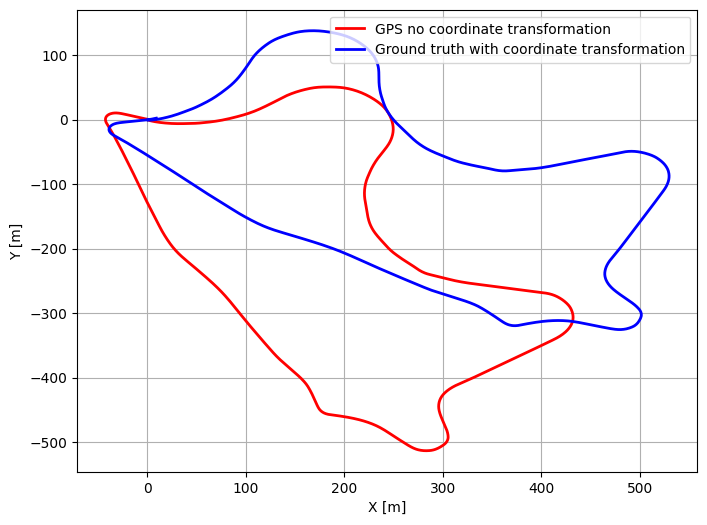

In [244]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

xs, ys, _ = GPS_measurements_in_meter[:, :gt_in_imu_coord_pd.shape[0]]
# xs, ys, _ = gps_in_imu_coord.T
ax.plot(xs, ys, lw=2, c='r', label="GPS no coordinate transformation")

xs, ys, _ = gt_in_imu_coord.T
ax.plot(xs, ys, lw=2, c='b', label="Ground truth with coordinate transformation")

# ax.set_xlim(-100, 450)
# ax.set_ylim(-100, 450)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [212]:
imu[:6, :3]

array([[ 0.        ,  0.56484234, -0.26010583],
       [ 0.11      ,  0.47516424,  0.08786964],
       [ 0.21      ,  0.66123157,  0.09608404],
       [ 0.31      ,  0.9076221 ,  0.19858183],
       [ 0.42      ,  0.99417759,  0.47077232],
       [ 0.52      ,  0.96916294,  0.33191918]])

In [211]:
IMU_outputs[:5, :3]

array([[ 0.56484234, -0.26010583, 10.04488795],
       [ 0.47516424,  0.08786964,  9.78647793],
       [ 0.66123157,  0.09608404,  9.50853161],
       [ 0.9076221 ,  0.19858183,  9.49410284],
       [ 0.99417759,  0.47077232,  9.86588825]])

In [213]:
imu_in_cam_coord[:5, :3]

array([[ 0.        , -0.55954953, -9.80354704],
       [ 0.11      , -0.90778079, -9.54342035],
       [ 0.21      , -0.91486517, -9.26868791],
       [ 0.31      , -1.01612169, -9.25840473],
       [ 0.42      , -1.28814622, -9.63144038]])

In [225]:
gt_in_imu_coord

array([[ 1.14259534, -0.8096661 ,  0.2296859 ],
       [ 1.43087229, -0.82961907,  0.23320554],
       [ 1.72368929, -0.84556089,  0.23487489],
       ...,
       [ 7.91784827,  1.77617269, -2.95616076],
       [ 8.60377678,  2.00521432, -2.95460759],
       [ 9.29690824,  2.23995254, -2.95385594]])

In [229]:
GPS_measurements_in_meter.T

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.27105023, -0.14811387,  0.01792907],
       [ 0.52005461, -0.28641655,  0.03144834],
       ...,
       [ 9.3069981 , -1.49015372, -2.77693872],
       [10.08002302, -1.59750764, -2.75026755],
       [10.78814003, -1.69375977, -2.72133807]])

(1594, 6)